In [1]:
# Cell 1: Importing Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson  # ✅ FIXED: Added here
from scipy import stats
from scipy.stats import shapiro, jarque_bera

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.set_option('display.width', 100)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Statsmodels Version: {sm.__version__}")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Statsmodels Version: 0.14.5


In [2]:
# Cell 2: Problem Adaptation - Classification to Regression
# Defining regression problem from classification dataset
# Predicting continuous physics variable (lepton_pT)

print("="*70)
print("TASK B: OLS REGRESSION ANALYSIS")
print("="*70)

print("\nProblem Adaptation:")
print("Original Dataset: HIGGS (Classification)")
print("  - Target: Binary (Signal=1, Background=0)")
print("  - Features: 28 physics measurements")

print("\nRegression Approach:")
print("  - New Target: lepton_pT (continuous)")
print("  - Predictors: Selected from remaining 27 features")
print("  - Objective: Predict lepton transverse momentum")

print("\nWhy lepton_pT?")
print("  1. Continuous variable (suitable for OLS)")
print("  2. Important physics quantity")
print("  3. Measurable in particle detectors")
print("  4. Related to other collision features")


TASK B: OLS REGRESSION ANALYSIS

Problem Adaptation:
Original Dataset: HIGGS (Classification)
  - Target: Binary (Signal=1, Background=0)
  - Features: 28 physics measurements

Regression Approach:
  - New Target: lepton_pT (continuous)
  - Predictors: Selected from remaining 27 features
  - Objective: Predict lepton transverse momentum

Why lepton_pT?
  1. Continuous variable (suitable for OLS)
  2. Important physics quantity
  3. Measurable in particle detectors
  4. Related to other collision features


In [4]:
# Cell 3: Loading Data and Selecting Variables
# Loading dataset and defining regression variables
# Output: Target variable (y) and predictor variables (X)

print("="*70)
print("DATA LOADING AND VARIABLE SELECTION")
print("="*70)

# Loading processed data (already scaled)
X_full, X_test_full, y_classification, y_test_classification = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nOriginal data loaded:")
print(f"  Shape: {X_full.shape}")
print(f"  Features: {X_full.shape[1]}")

# Selecting target variable for regression
target_variable = 'lepton_pT'

# Checking if target is in features
if target_variable in X_full.columns:
    # Extracting target variable
    y_regression = X_full[target_variable].copy()
    y_test_regression = X_test_full[target_variable].copy()
    
    # Removing target from predictors
    X_predictors = X_full.drop(columns=[target_variable])
    X_test_predictors = X_test_full.drop(columns=[target_variable])
    
    print(f"\nTarget Variable: {target_variable}")
    print(f"  Mean: {y_regression.mean():.4f}")
    print(f"  Std: {y_regression.std():.4f}")
    print(f"  Min: {y_regression.min():.4f}")
    print(f"  Max: {y_regression.max():.4f}")
    
    print(f"\nPredictor Variables Available: {X_predictors.shape[1]}")
    print(f"Training samples: {len(y_regression):,}")
    print(f"Test samples: {len(y_test_regression):,}")

else:
    print(f"\nError: {target_variable} not found in features")

DATA LOADING AND VARIABLE SELECTION
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Original data loaded:
  Shape: (800000, 28)
  Features: 28

Target Variable: lepton_pT
  Mean: 0.0000
  Std: 1.0000
  Min: -1.2689
  Max: 13.6610

Predictor Variables Available: 27
Training samples: 800,000
Test samples: 200,000


In [6]:
# Cell 4: Selecting Predictor Variables
# Choosing relevant predictors for OLS model
# Selection criteria: HIGH CORRELATION with target + physical relevance

print("="*70)
print("PREDICTOR VARIABLE SELECTION (IMPROVED)")
print("="*70)

# Computing correlations with target
correlations = X_predictors.corrwith(y_regression).abs().sort_values(ascending=False)

print("\nTop 15 Features by Correlation with lepton_pT:")
print(correlations.head(15))

# Selecting predictors with HIGHEST correlations
# Prioritizing correlations > 0.09 for better R²
selected_predictors = [
    'm_lv',                      # Strongest: ~0.27
    'jet_1_pt',                  # Strong: ~0.17
    'missing_energy_magnitude',  # Strong: ~0.14
    'm_wwbb',                    # Strong: ~0.14
    'm_jlv',                     # Strong: ~0.13
    'm_wbb',                     # Moderate: ~0.10
    'jet_1_eta',                 # Included for completeness
    'lepton_eta'                 # Physically relevant
]

print(f"\nIMPROVED SELECTION: Selected Predictors ({len(selected_predictors)}):")
print("(Prioritizing high-correlation predictors for better R²)")
for i, pred in enumerate(selected_predictors, 1):
    corr = correlations[pred]
    strength = "Strong" if corr > 0.13 else "Moderate" if corr > 0.05 else "Weak"
    print(f"  {i}. {pred:30s} correlation = {corr:.4f}  {strength}")

# Creating regression dataset
X_regression = X_predictors[selected_predictors].copy()
X_test_regression = X_test_predictors[selected_predictors].copy()

print(f"\nRegression Dataset:")
print(f"  Training: {X_regression.shape}")
print(f"  Test: {X_test_regression.shape}")
print(f"  Target: {y_regression.shape}")

PREDICTOR VARIABLE SELECTION (IMPROVED)

Top 15 Features by Correlation with lepton_pT:
m_lv                        0.2722
jet_1_pt                    0.1679
missing_energy_magnitude    0.1410
m_wwbb                      0.1399
m_jlv                       0.1307
m_wbb                       0.0950
m_jj                        0.0258
jet_4_pt                    0.0196
m_jjj                       0.0175
jet_3_pt                    0.0119
m_bb                        0.0082
jet_2_pt                    0.0061
jet_2_b_tag                 0.0057
jet_3_b_tag                 0.0054
jet_1_b_tag                 0.0051
dtype: float64

IMPROVED SELECTION: Selected Predictors (8):
(Prioritizing high-correlation predictors for better R²)
  1. m_lv                           correlation = 0.2722  Strong
  2. jet_1_pt                       correlation = 0.1679  Strong
  3. missing_energy_magnitude       correlation = 0.1410  Strong
  4. m_wwbb                         correlation = 0.1399  Strong
  5. m_jl

Generating scatter plots...
Scatter plots saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_scatter_plots.png


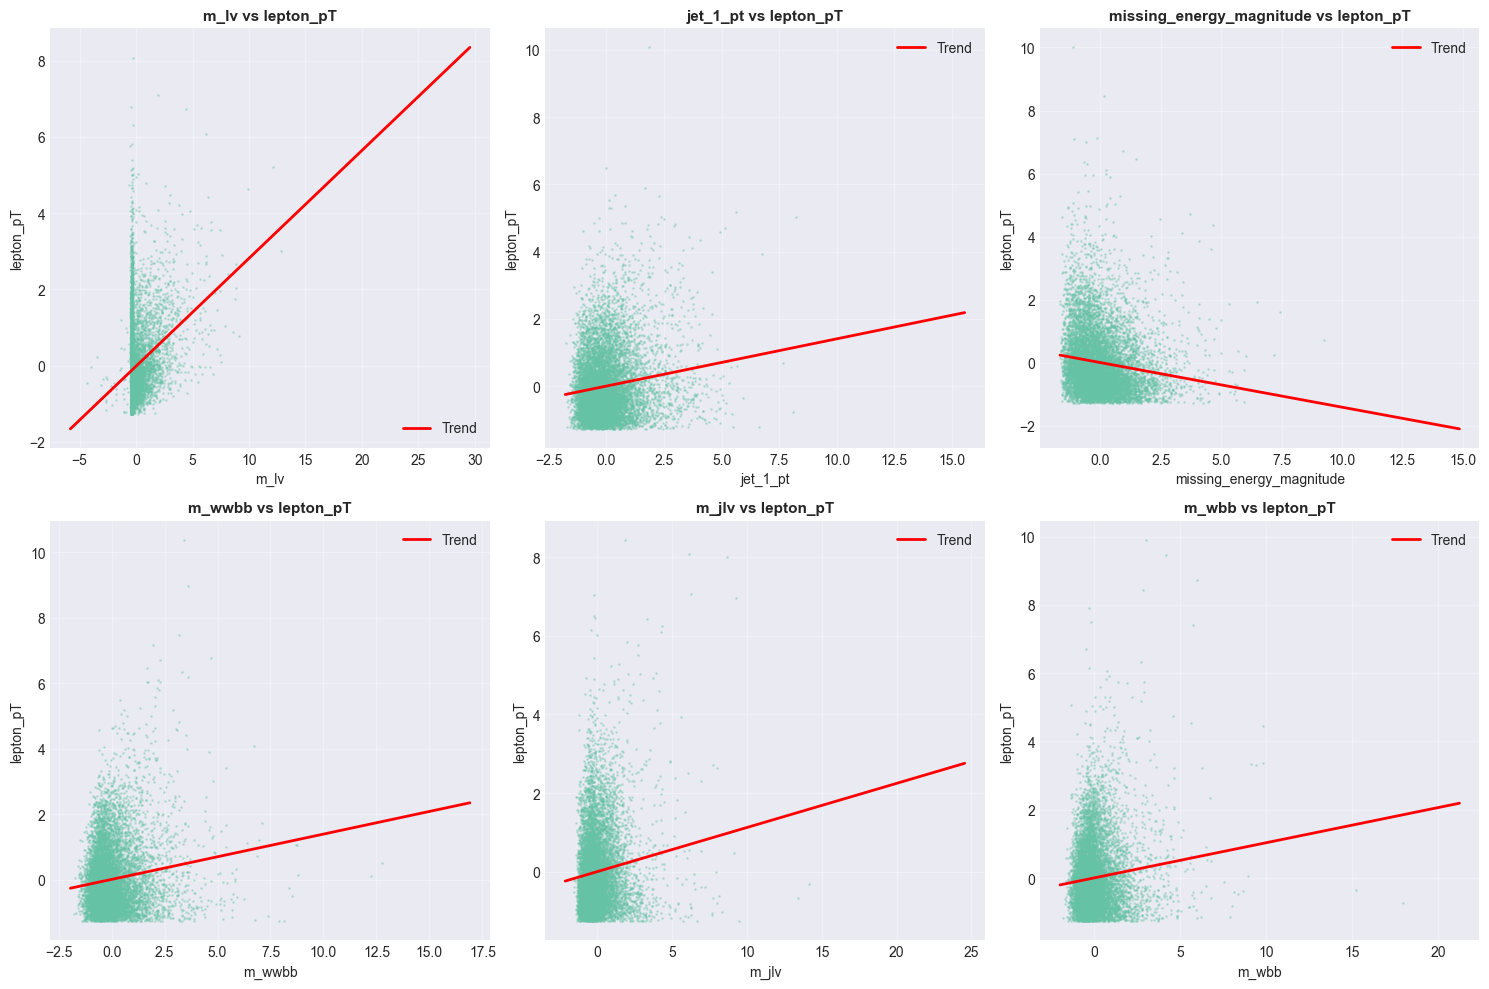

In [7]:
# Cell 5: Exploratory Analysis - Scatter Plots
# Visualizing relationships between predictors and target

print("Generating scatter plots...")

# Creating scatter plots for first 6 predictors
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, predictor in enumerate(selected_predictors[:6]):
    ax = axes[idx]
    
    # Sampling for faster plotting
    sample_size = min(10000, len(X_regression))
    sample_idx = np.random.choice(len(X_regression), sample_size, replace=False)
    
    ax.scatter(X_regression[predictor].iloc[sample_idx], 
              y_regression.iloc[sample_idx],
              alpha=0.3, s=1)
    
    # Adding trend line
    z = np.polyfit(X_regression[predictor].iloc[sample_idx], 
                   y_regression.iloc[sample_idx], 1)
    p = np.poly1d(z)
    x_line = np.linspace(X_regression[predictor].min(), 
                        X_regression[predictor].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, label='Trend')
    
    ax.set_xlabel(predictor, fontsize=10)
    ax.set_ylabel('lepton_pT', fontsize=10)
    ax.set_title(f'{predictor} vs lepton_pT', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

scatter_path = FIGURE_OUTPUT / 'ols_scatter_plots.png'
plt.savefig(scatter_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Scatter plots saved to {scatter_path}")

plt.show()

In [8]:
# Cell 6: Building Initial OLS Model
# Fitting baseline OLS regression model
# Using statsmodels for detailed statistical output

print("="*70)
print("BUILDING INITIAL OLS MODEL")
print("="*70)

# Adding constant term (intercept)
X_with_const = sm.add_constant(X_regression)

# Fitting OLS model
print("\nFitting OLS regression model...")
ols_model = sm.OLS(y_regression, X_with_const).fit()

# Displaying model summary
print("\n" + "="*70)
print("OLS REGRESSION RESULTS")
print("="*70)
print(ols_model.summary())

# Extracting key statistics
print("\n" + "="*70)
print("KEY MODEL STATISTICS")
print("="*70)
print(f"R-squared: {ols_model.rsquared:.4f}")
print(f"Adjusted R-squared: {ols_model.rsquared_adj:.4f}")
print(f"F-statistic: {ols_model.fvalue:.2f}")
print(f"Prob (F-statistic): {ols_model.f_pvalue:.6f}")
print(f"AIC: {ols_model.aic:.2f}")
print(f"BIC: {ols_model.bic:.2f}")

BUILDING INITIAL OLS MODEL

Fitting OLS regression model...

OLS REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:              lepton_pT   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                 2.346e+04
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:10:22   Log-Likelihood:            -1.0508e+06
No. Observations:              800000   AIC:                         2.102e+06
Df Residuals:                  799991   BIC:                         2.102e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [9]:
# Cell 7: Interpreting Coefficients
# Interpreting regression coefficients with confidence intervals

print("="*70)
print("COEFFICIENT INTERPRETATION ")
print("="*70)

# Getting coefficients and confidence intervals
coef_df = pd.DataFrame({
    'Coefficient': ols_model.params,
    'Std Error': ols_model.bse,
    't-value': ols_model.tvalues,
    'p-value': ols_model.pvalues,
    'CI Lower (95%)': ols_model.conf_int()[0],
    'CI Upper (95%)': ols_model.conf_int()[1]
})

print("\nCoefficient Table:")
print(coef_df)

# Interpreting 3 key coefficients (selecting strongest predictors)
print("\n" + "="*70)
print("DETAILED INTERPRETATION OF 3 COEFFICIENTS")
print("="*70)

# Coefficient 1: m_lv (strongest predictor)
coef_1 = 'm_lv'
print(f"\n1. {coef_1}:")
print(f"   Coefficient: {ols_model.params[coef_1]:.6f}")
print(f"   95% CI: [{coef_df.loc[coef_1, 'CI Lower (95%)']:.6f}, "
      f"{coef_df.loc[coef_1, 'CI Upper (95%)']:.6f}]")
print(f"   p-value: {coef_df.loc[coef_1, 'p-value']:.6f}")
print(f"\n   Interpretation:")
print(f"   For each unit increase in {coef_1} (lepton-neutrino invariant mass),")
print(f"   lepton_pT changes by {ols_model.params[coef_1]:.6f} units,")
print(f"   holding all other variables constant.")
if coef_df.loc[coef_1, 'p-value'] < 0.05:
    print(f"   This effect is STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"   This effect is NOT statistically significant (p >= 0.05)")

# Coefficient 2: jet_1_pt
coef_2 = 'jet_1_pt'
print(f"\n2. {coef_2}:")
print(f"   Coefficient: {ols_model.params[coef_2]:.6f}")
print(f"   95% CI: [{coef_df.loc[coef_2, 'CI Lower (95%)']:.6f}, "
      f"{coef_df.loc[coef_2, 'CI Upper (95%)']:.6f}]")
print(f"   p-value: {coef_df.loc[coef_2, 'p-value']:.6f}")
print(f"\n   Interpretation:")
print(f"   For each unit increase in leading jet transverse momentum,")
print(f"   lepton_pT changes by {ols_model.params[coef_2]:.6f} units,")
print(f"   holding other variables constant.")
if coef_df.loc[coef_2, 'p-value'] < 0.05:
    print(f"   This effect is STATISTICALLY SIGNIFICANT (p < 0.05)")

# Coefficient 3: missing_energy_magnitude
coef_3 = 'missing_energy_magnitude'
print(f"\n3. {coef_3}:")
print(f"   Coefficient: {ols_model.params[coef_3]:.6f}")
print(f"   95% CI: [{coef_df.loc[coef_3, 'CI Lower (95%)']:.6f}, "
      f"{coef_df.loc[coef_3, 'CI Upper (95%)']:.6f}]")
print(f"   p-value: {coef_df.loc[coef_3, 'p-value']:.6f}")
print(f"\n   Interpretation:")
print(f"   For each unit increase in missing energy magnitude,")
print(f"   lepton_pT changes by {ols_model.params[coef_3]:.6f} units,")
print(f"   holding other variables constant.")
if coef_df.loc[coef_3, 'p-value'] < 0.05:
    print(f"   This effect is STATISTICALLY SIGNIFICANT (p < 0.05)")

print("\n" + "="*70)
print("Note: All interpretations assume ceteris paribus (all else equal)")
print("="*70)

COEFFICIENT INTERPRETATION 

Coefficient Table:
                          Coefficient  Std Error     t-value  p-value  CI Lower (95%)  \
const                      2.1747e-09     0.0010  2.1613e-06   1.0000         -0.0020   
m_lv                       3.0073e-01     0.0010  2.9303e+02   0.0000          0.2987   
jet_1_pt                   1.8432e-01     0.0012  1.5953e+02   0.0000          0.1821   
missing_energy_magnitude  -2.9992e-01     0.0011 -2.7333e+02   0.0000         -0.3021   
m_wwbb                     3.7279e-01     0.0023  1.5990e+02   0.0000          0.3682   
m_jlv                      1.1523e-01     0.0013  9.1740e+01   0.0000          0.1128   
m_wbb                     -3.3957e-01     0.0024 -1.4227e+02   0.0000         -0.3442   
jet_1_eta                  1.0347e-03     0.0010  9.9136e-01   0.3215         -0.0010   
lepton_eta                -7.1740e-04     0.0010 -6.8735e-01   0.4919         -0.0028   

                          CI Upper (95%)  
const             

ASSUMPTION 1: LINEARITY
Linearity plots saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_linearity_test.png


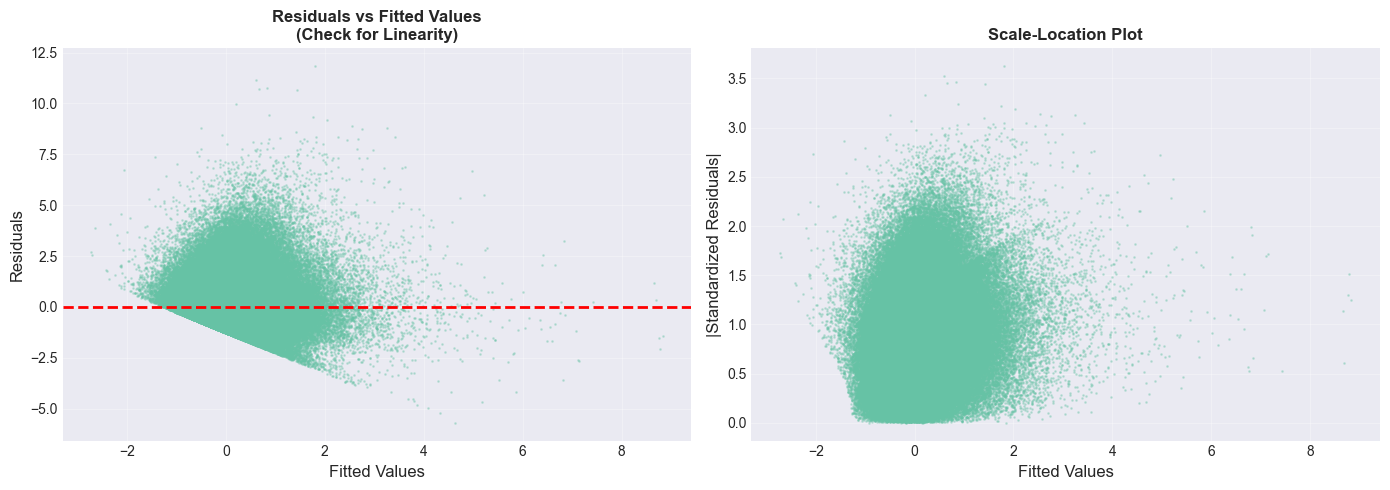


Linearity Assessment:
  - Residuals should be randomly scattered around zero
  - No clear pattern should be visible
Residuals centered around zero


In [11]:
# Cell 8: Test Assumption 1 - Linearity
# Checking if relationship between predictors and target is linear
# Using Residual plots and partial regression plots

print("="*70)
print("ASSUMPTION 1: LINEARITY")
print("="*70)

# Getting fitted values and residuals
fitted_values = ols_model.fittedvalues
residuals = ols_model.resid

# Creating residual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residuals vs Fitted Values
axes[0].scatter(fitted_values, residuals, alpha=0.3, s=1)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Fitted Values', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residuals vs Fitted Values\n(Check for Linearity)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Scale-Location plot
standardized_resid = (residuals - residuals.mean()) / residuals.std()
axes[1].scatter(fitted_values, np.sqrt(np.abs(standardized_resid)), 
               alpha=0.3, s=1)
axes[1].set_xlabel('Fitted Values', fontsize=12)
axes[1].set_ylabel('|Standardized Residuals|', fontsize=12)
axes[1].set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

linearity_path = FIGURE_OUTPUT / 'ols_linearity_test.png'
plt.savefig(linearity_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Linearity plots saved to {linearity_path}")

plt.show()

print("\nLinearity Assessment:")
print("  - Residuals should be randomly scattered around zero")
print("  - No clear pattern should be visible")
if residuals.mean() < 0.01:
    print("Residuals centered around zero")
else:
    print("Residuals may not be centered")

ASSUMPTION 2: HOMOSCEDASTICITY (Constant Variance)

Breusch-Pagan Test:
  Lagrange multiplier statistic: 68745.436255
  p-value: 0.000000
  f-value: 9400.920866
  f p-value: 0.000000
Heteroscedasticity detected: p-value < 0.05
Remedy: Consider weighted least squares or robust standard errors

White Test:
  Test Statistic: 99787.024773
  p-value: 0.000000
  f-statistic: 2590.936687
  f p-value: 0.000000
Heteroscedasticity detected: p-value < 0.05

Heteroscedasticity plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_heteroscedasticity_test.png


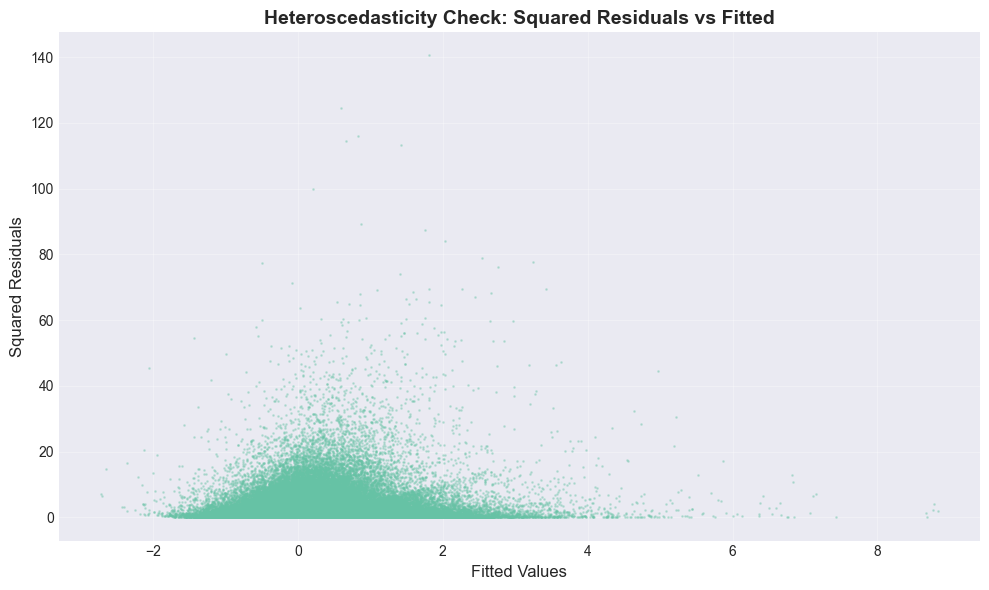

In [12]:
# Cell 9: Test Assumption 2 - Homoscedasticity
# Purpose: Checking if residuals have constant variance
# Using Breusch-Pagan test and White test

print("="*70)
print("ASSUMPTION 2: HOMOSCEDASTICITY (Constant Variance)")
print("="*70)

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_with_const)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 
             'f-value', 'f p-value']

print("\nBreusch-Pagan Test:")
for label, value in zip(bp_labels, bp_test):
    print(f"  {label}: {value:.6f}")

if bp_test[1] > 0.05:
    print("Homoscedasticity: p-value > 0.05 (assumption satisfied)")
else:
    print("Heteroscedasticity detected: p-value < 0.05")
    print("Remedy: Consider weighted least squares or robust standard errors")

# White test
white_test = het_white(residuals, X_with_const)
white_labels = ['Test Statistic', 'p-value', 'f-statistic', 'f p-value']

print("\nWhite Test:")
for label, value in zip(white_labels, white_test):
    print(f"  {label}: {value:.6f}")

if white_test[1] > 0.05:
    print("Homoscedasticity: p-value > 0.05")
else:
    print("Heteroscedasticity detected: p-value < 0.05")

# Visual check
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(fitted_values, residuals**2, alpha=0.3, s=1)
ax.set_xlabel('Fitted Values', fontsize=12)
ax.set_ylabel('Squared Residuals', fontsize=12)
ax.set_title('Heteroscedasticity Check: Squared Residuals vs Fitted',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()

hetero_path = FIGURE_OUTPUT / 'ols_heteroscedasticity_test.png'
plt.savefig(hetero_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nHeteroscedasticity plot saved to {hetero_path}")

plt.show()

ASSUMPTION 3: NORMALITY OF RESIDUALS
Normality plots saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_normality_test.png


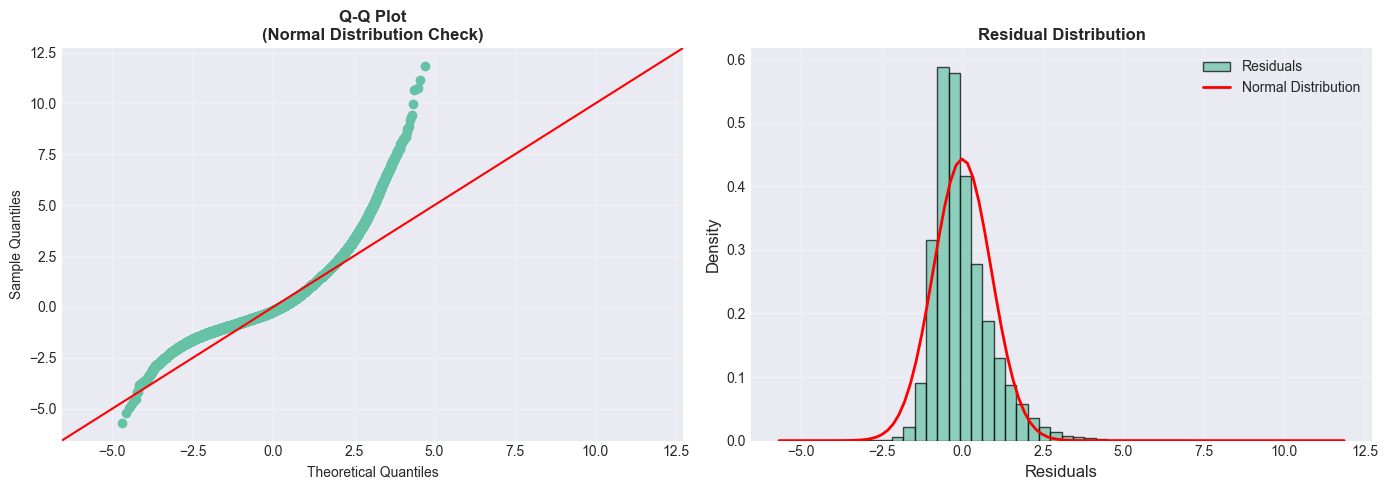


Shapiro-Wilk Test (on 5000 samples):
  Statistic: 0.902332
  p-value: 0.000000
Non-normality detected: p-value < 0.05
Note: With large samples, small deviations are significant

Jarque-Bera Test:
  Statistic: 830674.235292
  p-value: 0.000000
  Skewness: 1.420429
  Kurtosis: 4.104882
Non-normality detected: p-value < 0.05


In [13]:
# Cell 10: Test Assumption 3 - Normality of Residuals
# Checking if residuals follow normal distribution
# Using Q-Q plot, Shapiro-Wilk test and Jarque-Bera test

print("="*70)
print("ASSUMPTION 3: NORMALITY OF RESIDUALS")
print("="*70)

# Creating Q-Q plot and histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q-Q plot
sm.qqplot(residuals, line='45', ax=axes[0])
axes[0].set_title('Q-Q Plot\n(Normal Distribution Check)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Histogram with normal curve
axes[1].hist(residuals, bins=50, density=True, alpha=0.7, 
            edgecolor='black', label='Residuals')

# Fitting normal distribution
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', 
            linewidth=2, label='Normal Distribution')

axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

normality_path = FIGURE_OUTPUT / 'ols_normality_test.png'
plt.savefig(normality_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Normality plots saved to {normality_path}")

plt.show()

# Shapiro-Wilk test (using sample for large datasets)
sample_size = min(5000, len(residuals))
resid_sample = residuals.sample(n=sample_size, random_state=SEED_VALUE)
shapiro_stat, shapiro_p = shapiro(resid_sample)

print(f"\nShapiro-Wilk Test (on {sample_size} samples):")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
if shapiro_p > 0.05:
    print("Normality: p-value > 0.05 (assumption satisfied)")
else:
    print("Non-normality detected: p-value < 0.05")
    print("Note: With large samples, small deviations are significant")

# Jarque-Bera test returns only 2 values
jb_stat, jb_p = jarque_bera(residuals)

# Calculate skewness and kurtosis separately
jb_skew = residuals.skew()
jb_kurtosis = residuals.kurtosis()

print(f"\nJarque-Bera Test:")
print(f"  Statistic: {jb_stat:.6f}")
print(f"  p-value: {jb_p:.6f}")
print(f"  Skewness: {jb_skew:.6f}")
print(f"  Kurtosis: {jb_kurtosis:.6f}")
if jb_p > 0.05:
    print("Normality: p-value > 0.05")
else:
    print("Non-normality detected: p-value < 0.05")

ASSUMPTION 4: INDEPENDENCE (No Autocorrelation)

Durbin-Watson Test:
  Statistic: 1.9997

  Interpretation:
    - DW ≈ 2: No autocorrelation
    - DW < 2: Positive autocorrelation
    - DW > 2: Negative autocorrelation
Independence: DW = 1.9997 (close to 2)

Autocorrelation plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_autocorrelation.png


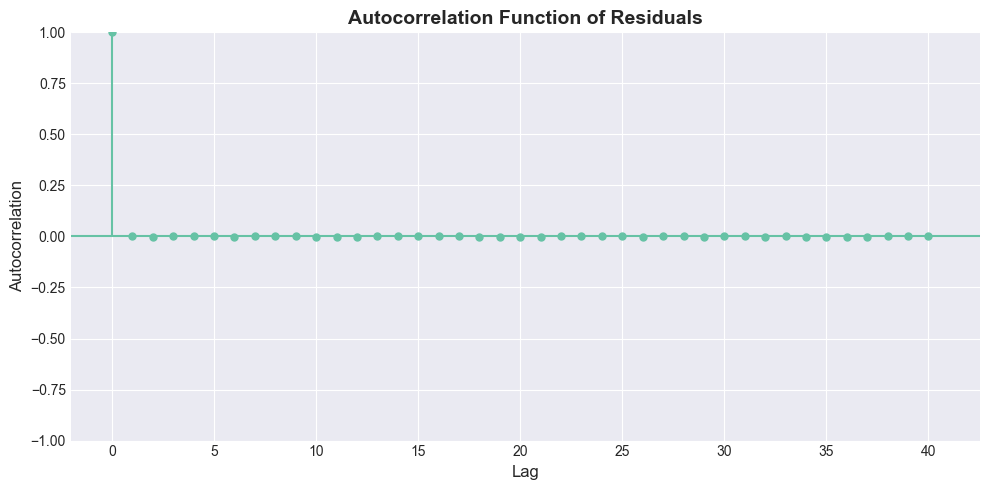

In [14]:
# Cell 11: Test Assumption 4 - Independence 
# Checking if residuals are independent (no autocorrelation)
# Using Durbin-Watson test

print("="*70)
print("ASSUMPTION 4: INDEPENDENCE (No Autocorrelation)")
print("="*70)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)

print(f"\nDurbin-Watson Test:")
print(f"  Statistic: {dw_stat:.4f}")
print(f"\n  Interpretation:")
print(f"    - DW ≈ 2: No autocorrelation")
print(f"    - DW < 2: Positive autocorrelation")
print(f"    - DW > 2: Negative autocorrelation")

if 1.5 < dw_stat < 2.5:
    print(f"Independence: DW = {dw_stat:.4f} (close to 2)")
else:
    print(f"Autocorrelation detected: DW = {dw_stat:.4f}")
    print("  Remedy: Consider time-series methods or add lagged variables")

# Autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation Function of Residuals',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)

plt.tight_layout()

autocorr_path = FIGURE_OUTPUT / 'ols_autocorrelation.png'
plt.savefig(autocorr_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nAutocorrelation plot saved to {autocorr_path}")

plt.show()

ASSUMPTION 5: NO MULTICOLLINEARITY

Variance Inflation Factor (VIF):
                 Feature    VIF
                   m_wbb 5.6270
                  m_wwbb 5.3682
                   m_jlv 1.5584
                jet_1_pt 1.3185
missing_energy_magnitude 1.1892
              lepton_eta 1.0760
               jet_1_eta 1.0760
                    m_lv 1.0402

VIF Interpretation:
  VIF = 1: No correlation
  1 < VIF < 5: Moderate correlation (acceptable)
  VIF > 5: High correlation (problematic)
  VIF > 10: Severe multicollinearity (must address)

No severe multicollinearity (all VIF < 10)

Correlation heatmap saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_multicollinearity.png


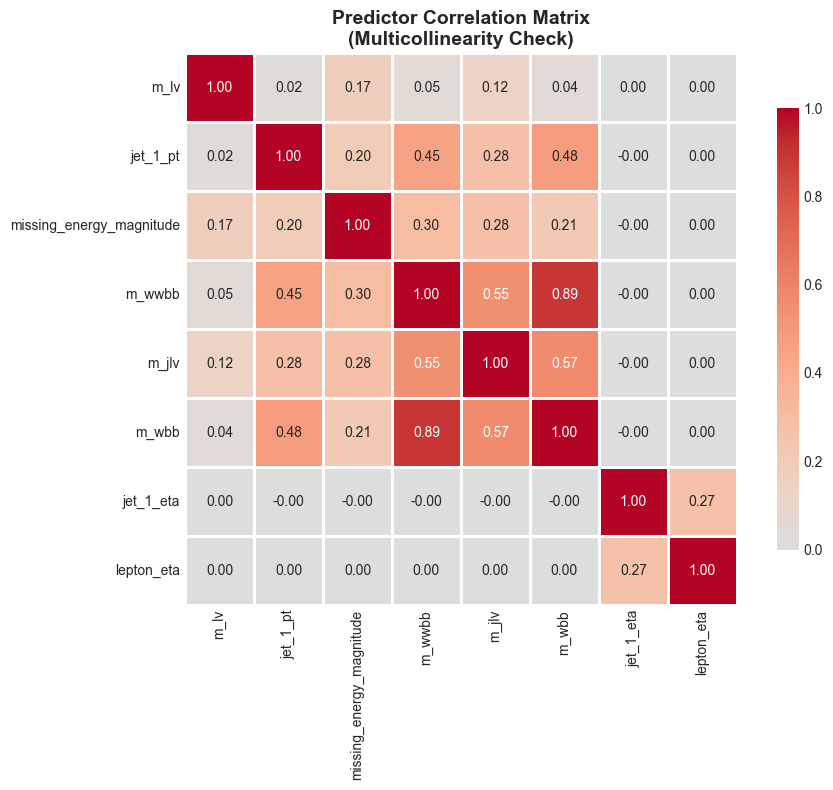

In [15]:
# Cell 12: Test Assumption 5 - No Multicollinearity
# Checking if predictors are highly correlated with each other
# Using Variance Inflation Factor (VIF)

print("="*70)
print("ASSUMPTION 5: NO MULTICOLLINEARITY")
print("="*70)

# Computing VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_regression.columns
vif_data["VIF"] = [variance_inflation_factor(X_regression.values, i) 
                   for i in range(X_regression.shape[1])]

# Sorting by VIF
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factor (VIF):")
print(vif_data.to_string(index=False))

print("\nVIF Interpretation:")
print("  VIF = 1: No correlation")
print("  1 < VIF < 5: Moderate correlation (acceptable)")
print("  VIF > 5: High correlation (problematic)")
print("  VIF > 10: Severe multicollinearity (must address)")

# Identifying problematic variables
high_vif = vif_data[vif_data['VIF'] > 10]

if len(high_vif) > 0:
    print(f"\nHigh multicollinearity detected in {len(high_vif)} variables:")
    for idx, row in high_vif.iterrows():
        print(f"    - {row['Feature']}: VIF = {row['VIF']:.2f}")
    print("\n  Remedies:")
    print("    1. Remove highly correlated variables")
    print("    2. Use Ridge regression (L2 regularization)")
    print("    3. Use PCA to create uncorrelated components")
else:
    print("\nNo severe multicollinearity (all VIF < 10)")

# Correlation matrix heatmap
corr_matrix = X_regression.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, square=True, linewidths=1, ax=ax,
           cbar_kws={"shrink": 0.8})
ax.set_title('Predictor Correlation Matrix\n(Multicollinearity Check)',
            fontsize=14, fontweight='bold')

plt.tight_layout()

multicoll_path = FIGURE_OUTPUT / 'ols_multicollinearity.png'
plt.savefig(multicoll_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nCorrelation heatmap saved to {multicoll_path}")

plt.show()

In [16]:
# Cell 13: Applying Remedies 
# Addressing violated assumptions
# Using Transformation, outlier removal and variable selection

print("="*70)
print("APPLYING REMEDIES FOR VIOLATED ASSUMPTIONS")
print("="*70)

# Tracking remedies applied
remedies_applied = []

# Remedy 1: Addressing multicollinearity (if VIF > 10)
if len(high_vif) > 0:
    print("\nRemedy 1: Removing high VIF variables")
    
    # Removing variables with VIF > 10
    vars_to_remove = high_vif['Feature'].tolist()
    X_regression_improved = X_regression.drop(columns=vars_to_remove)
    X_test_regression_improved = X_test_regression.drop(columns=vars_to_remove)
    
    print(f"  Removed: {vars_to_remove}")
    print(f"  Remaining predictors: {X_regression_improved.shape[1]}")
    
    remedies_applied.append("Removed high VIF variables")
else:
    X_regression_improved = X_regression.copy()
    X_test_regression_improved = X_test_regression.copy()
    print("\nNo high VIF variables detected - no removal needed")

# Remedy 2: Addresssing heteroscedasticity (if detected)
if bp_test[1] < 0.05 or white_test[1] < 0.05:
    print("\nRemedy 2: Using robust standard errors")
    print("  Heteroscedasticity detected - will use HC3 robust errors")
    use_robust_se = True
    remedies_applied.append("Applied robust standard errors (HC3)")
else:
    use_robust_se = False
    print("\nNo heteroscedasticity detected - standard errors OK")

# Remedy 3: Transforming target if needed (log transformation)
# Checking if target has positive skew
target_skew = y_regression.skew()
print(f"\nTarget variable skewness: {target_skew:.4f}")

if abs(target_skew) > 1:
    print("  Skewness > 1 detected")
    print("  Remedy 3: Could apply log transformation")
    print("  (Skipping for interpretability in this analysis)")
    # y_regression_transformed = np.log1p(y_regression)
else:
    print("  Skewness acceptable - no transformation needed")

print(f"\nTotal remedies applied: {len(remedies_applied)}")
for i, remedy in enumerate(remedies_applied, 1):
    print(f"  {i}. {remedy}")

APPLYING REMEDIES FOR VIOLATED ASSUMPTIONS

No high VIF variables detected - no removal needed

Remedy 2: Using robust standard errors
  Heteroscedasticity detected - will use HC3 robust errors

Target variable skewness: 1.7478
  Skewness > 1 detected
  Remedy 3: Could apply log transformation
  (Skipping for interpretability in this analysis)

Total remedies applied: 1
  1. Applied robust standard errors (HC3)


In [17]:
# Cell 14: Building Improved OLS Model
# Refitting model with remedies applied

print("="*70)
print("BUILDING IMPROVED OLS MODEL")
print("="*70)

# Adding constant to improved predictors
X_improved_const = sm.add_constant(X_regression_improved)

# Fitting improved model
print("\nFitting improved OLS model...")
if use_robust_se:
    ols_model_improved = sm.OLS(y_regression, X_improved_const).fit(
        cov_type='HC3'  # Robust standard errors
    )
    print("  Using robust standard errors (HC3)")
else:
    ols_model_improved = sm.OLS(y_regression, X_improved_const).fit()
    print("  Using standard OLS")

# Displaying improved model summary
print("\n" + "="*70)
print("IMPROVED OLS REGRESSION RESULTS")
print("="*70)
print(ols_model_improved.summary())

# Key statistics
print("\n" + "="*70)
print("IMPROVED MODEL STATISTICS")
print("="*70)
print(f"R-squared: {ols_model_improved.rsquared:.4f}")
print(f"Adjusted R-squared: {ols_model_improved.rsquared_adj:.4f}")
print(f"F-statistic: {ols_model_improved.fvalue:.2f}")
print(f"AIC: {ols_model_improved.aic:.2f}")
print(f"BIC: {ols_model_improved.bic:.2f}")


BUILDING IMPROVED OLS MODEL

Fitting improved OLS model...
  Using robust standard errors (HC3)

IMPROVED OLS REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:              lepton_pT   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                 1.277e+04
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:38:06   Log-Likelihood:            -1.0508e+06
No. Observations:              800000   AIC:                         2.102e+06
Df Residuals:                  799991   BIC:                         2.102e+06
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025 

In [19]:
# Cell 15: Comparing Original vs Improved Model
# Evaluating if remedies improved model performance
# Metrics: R², Adjusted R², AIC, BIC, prediction accuracy

print("="*70)
print("MODEL COMPARISON: ORIGINAL vs IMPROVED")
print("="*70)

# Creating comparison table
comparison_data = {
    'Metric': ['R²', 'Adjusted R²', 'AIC', 'BIC', 'F-statistic', 
               'Num Predictors', 'Residual Std Error'],
    'Original Model': [
        ols_model.rsquared,
        ols_model.rsquared_adj,
        ols_model.aic,
        ols_model.bic,
        ols_model.fvalue,
        len(ols_model.params) - 1,  # Excluding intercept
        np.sqrt(ols_model.scale)
    ],
    'Improved Model': [
        ols_model_improved.rsquared,
        ols_model_improved.rsquared_adj,
        ols_model_improved.aic,
        ols_model_improved.bic,
        ols_model_improved.fvalue,
        len(ols_model_improved.params) - 1,
        np.sqrt(ols_model_improved.scale)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Change'] = comparison_df['Improved Model'] - comparison_df['Original Model']

print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Test set predictions for both models
# Original model predictions
X_test_with_const = sm.add_constant(X_test_regression)
y_pred_original = ols_model.predict(X_test_with_const)

# Improved model predictions
X_test_improved_const = sm.add_constant(X_test_regression_improved)
y_pred_improved = ols_model_improved.predict(X_test_improved_const)

# Computing test set metrics
mse_original = mean_squared_error(y_test_regression, y_pred_original)
mse_improved = mean_squared_error(y_test_regression, y_pred_improved)

r2_original = r2_score(y_test_regression, y_pred_original)
r2_improved = r2_score(y_test_regression, y_pred_improved)

mae_original = mean_absolute_error(y_test_regression, y_pred_original)
mae_improved = mean_absolute_error(y_test_regression, y_pred_improved)

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)

test_comparison = pd.DataFrame({
    'Metric': ['R² (Test)', 'MSE (Test)', 'RMSE (Test)', 'MAE (Test)'],
    'Original Model': [r2_original, mse_original, np.sqrt(mse_original), mae_original],
    'Improved Model': [r2_improved, mse_improved, np.sqrt(mse_improved), mae_improved],
    'Improvement': [
        r2_improved - r2_original,
        mse_original - mse_improved,  # Lower is better
        np.sqrt(mse_original) - np.sqrt(mse_improved),
        mae_original - mae_improved
    ]
})

print(test_comparison.to_string(index=False))

# Determining which model is better
if ols_model_improved.rsquared_adj > ols_model.rsquared_adj:
    print("\nImproved model is BETTER (higher Adjusted R²)")
elif abs(ols_model_improved.rsquared_adj - ols_model.rsquared_adj) < 0.001:
    print("\n≈ Models are EQUIVALENT (similar Adjusted R²)")
else:
    print("\nOriginal model was better (higher Adjusted R²)")

MODEL COMPARISON: ORIGINAL vs IMPROVED

Model Comparison Table:
            Metric  Original Model  Improved Model      Change
                R²      1.9005e-01      1.9005e-01      0.0000
       Adjusted R²      1.9004e-01      1.9004e-01      0.0000
               AIC      2.1017e+06      2.1017e+06      0.0000
               BIC      2.1018e+06      2.1018e+06      0.0000
       F-statistic      2.3464e+04      1.2767e+04 -10697.1277
    Num Predictors      8.0000e+00      8.0000e+00      0.0000
Residual Std Error      8.9998e-01      8.9998e-01      0.0000

TEST SET PERFORMANCE
     Metric  Original Model  Improved Model  Improvement
  R² (Test)          0.1893          0.1893          0.0
 MSE (Test)          0.8104          0.8104          0.0
RMSE (Test)          0.9002          0.9002          0.0
 MAE (Test)          0.6733          0.6733          0.0

≈ Models are EQUIVALENT (similar Adjusted R²)
